In [1]:
import os
import re
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio as imageio
from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, UpSampling2D, MaxPool2D, MaxPooling2D, Concatenate, LeakyReLU, concatenate, Dropout, ReLU, Activation, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
WIDTH, HEIGHT = 256, 256
BATCH_SIZE = 16
lr = 1e-04
epochs = 100
image_size = [256,256]

In [3]:
model_path = "/kaggle/working/unet_carlo.h5"
csv_path = "/kaggle/working/csvlogger.csv"

# Helping Funtion for Data Preprocessing

In [4]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
#get data
def read_data(path):
    images = sorted(glob(os.path.join(path, "CameraRGB/*")))
    masks = sorted(glob(os.path.join(path, "CameraSeg/*")))
    
    return images, masks

In [6]:
def show_images_with_masks(image_dir, mask_dir):
    #image_files = sorted(os.listdir(image_dir))
    #mask_files = sorted(os.listdir(mask_dir))

    # Ensure equal number of images and masks
    num_files = min(len(image_dir), len(image_dir))

    # Display 5 images and masks
    num_display = min(num_files, 5)
    fig, axs = plt.subplots(num_display, 2, figsize=(10, 10))

    for i in range(num_display):

        image = cv2.imread(image_dir[i])
        mask = cv2.imread(mask_dir[i])[:,:,2]

        # Display image
        axs[i, 0].imshow(image)
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Image')

        # Display mask
        axs[i, 1].imshow(mask)
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_filenames,
                 mask_filenames,
                 batch_size=BATCH_SIZE,
                 shuffle=True):

        self.img_filenames = img_filenames
        self.mask_filenames = mask_filenames
        self.filenames = list(zip(img_filenames, mask_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle= shuffle
        self.n = len(self.img_filenames)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __get_data(self, batches):
        imgs=[]
        segs=[]
        for img_file, mask_file in batches:
            image = cv2.imread(img_file)
            image = cv2.resize(image, (WIDTH, HEIGHT))
            image = image / 255.
            
            mask = cv2.imread(mask_file)
            mask = cv2.resize(mask, (WIDTH, HEIGHT))[:, :, 2]

            imgs.append(image)
            segs.append(mask)

        return np.array(imgs), np.array(segs)
    
    def __getitem__(self, index):

        batches = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(batches)

        return (X, y)

    def __len__(self):

        return self.n // self.batch_size

In [8]:
#set color to image
def give_color_to_seg_img(seg, n_classes=13):
    seg_img = np.zeros( (seg.shape[0],seg.shape[1], 3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

# Data Preparation and preprocessing

In [9]:
org_path = "/kaggle/input/lyft-udacity-challenge/dataA/dataA"
images, masks = read_data(org_path)

In [10]:
test_path = "/kaggle/input/lyft-udacity-challenge/dataB/dataB"
test_images, test_masks = read_data(test_path)

In [11]:
train_gen = DataGenerator(images, masks)
test_gen = DataGenerator(test_images[0:700], test_masks[0:700])

In [12]:
for x, y in test_gen:
    break
x.shape, y.shape

((16, 256, 256, 3), (16, 256, 256))

In [13]:
for x, y in train_gen:
    break
x.shape, y.shape

((16, 256, 256, 3), (16, 256, 256))

(-0.5, 255.5, 255.5, -0.5)

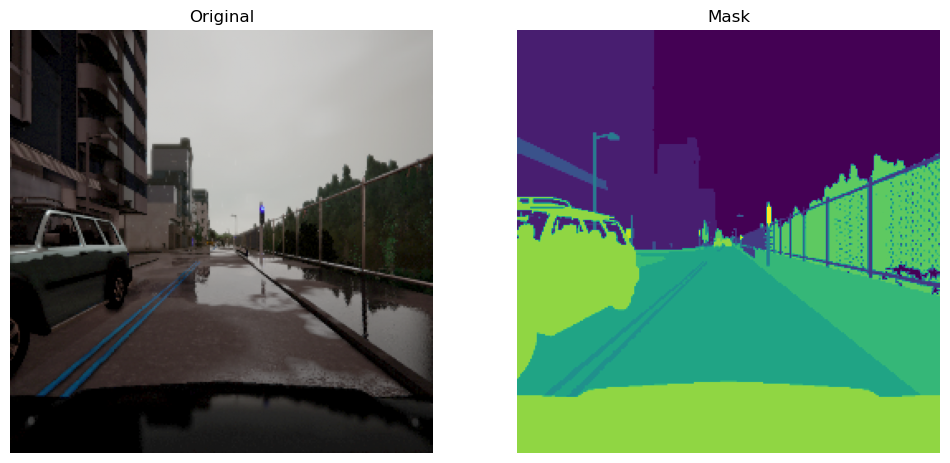

In [14]:
#visualize image and mask
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0])
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(y[0])
plt.title('Mask')
plt.axis('off')

## U-Net

In [15]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)


    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(13, (1,1), padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs, name='U-Net')
    return model

In [16]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
def lrfn(epoch):
    if epoch > 15:
        return 2e-4
    elif epoch > 25:
        return 1e-4
    return 1e-3

In [18]:
metrics = ['accuracy', Recall(), Precision()]
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
#Callbacks
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: lrfn(step))
Callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True), 
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    lr_callback
]

# Training

In [20]:
train_steps = len(train_gen)
val_steps = len(test_gen)

history = model.fit(train_gen, validation_data=test_gen, 
                    steps_per_epoch=train_steps, validation_steps=val_steps, 
                    epochs = 20, verbose=1, callbacks=Callbacks)

Epoch 1/20
62/62 [==============================] - ETA: 0s - loss: 1.2090 - accuracy: 0.6693
Epoch 1: val_loss improved from inf to 5.24415, saving model to /kaggle/working/unet_carlo.h5
62/62 [==============================] - 104s 1s/step - loss: 1.2090 - accuracy: 0.6693 - val_loss: 5.2441 - val_accuracy: 0.3046 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.8139
Epoch 2: val_loss improved from 5.24415 to 2.27540, saving model to /kaggle/working/unet_carlo.h5
62/62 [==============================] - 49s 793ms/step - loss: 0.6865 - accuracy: 0.8139 - val_loss: 2.2754 - val_accuracy: 0.3953 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8725
Epoch 3: val_loss improved from 2.27540 to 1.99845, saving model to /kaggle/working/unet_carlo.h5
62/62 [==============================] - 48s 772ms/step - loss: 0.4952 - accuracy: 0.8725 - val_loss: 1.9984 - val_accuracy: 0.4715 - lr: 0.

# Model's Performance visualization

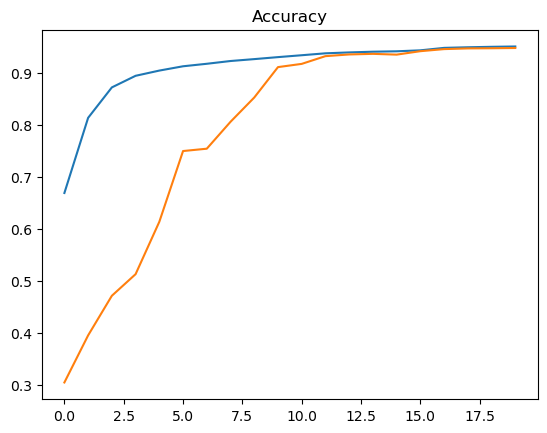

In [21]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.show()

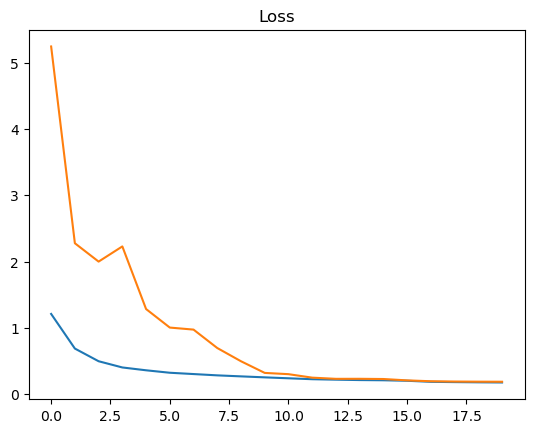

In [22]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.show()

# Prediction and Visualization

1/1 [==============================] - 0s 422ms/step


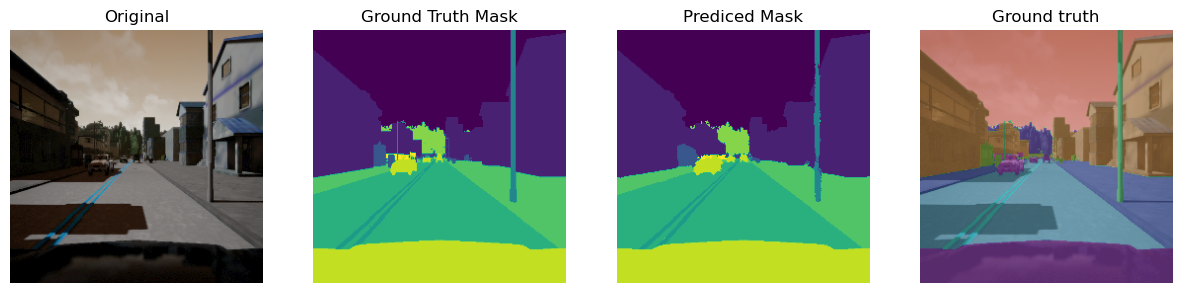

1/1 [==============================] - 0s 35ms/step


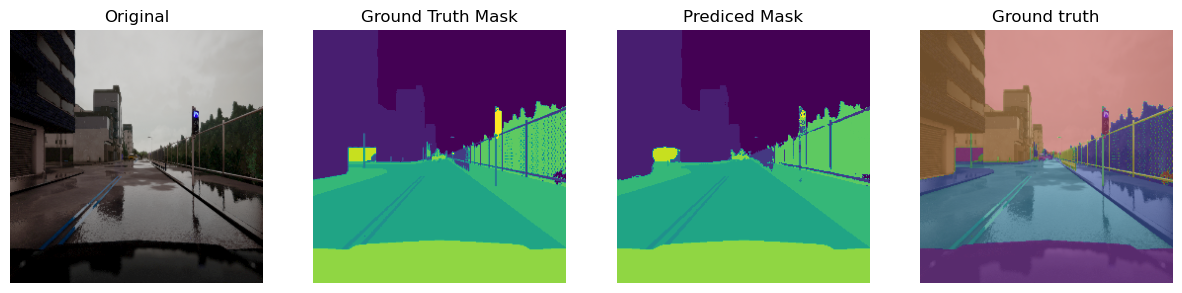

1/1 [==============================] - 0s 29ms/step


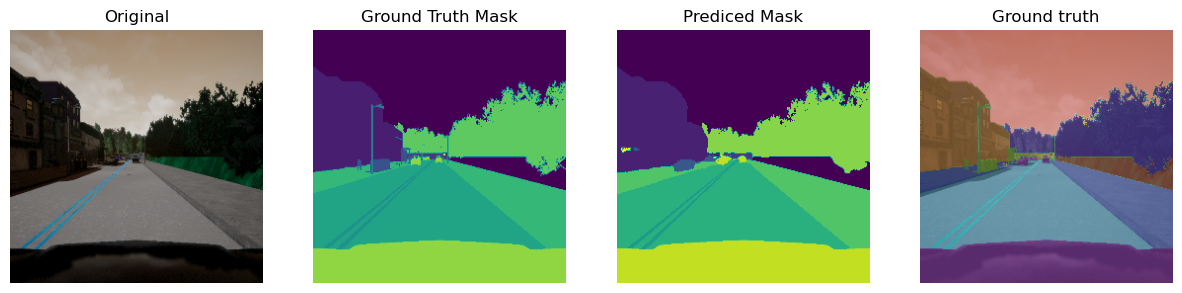

1/1 [==============================] - 0s 29ms/step


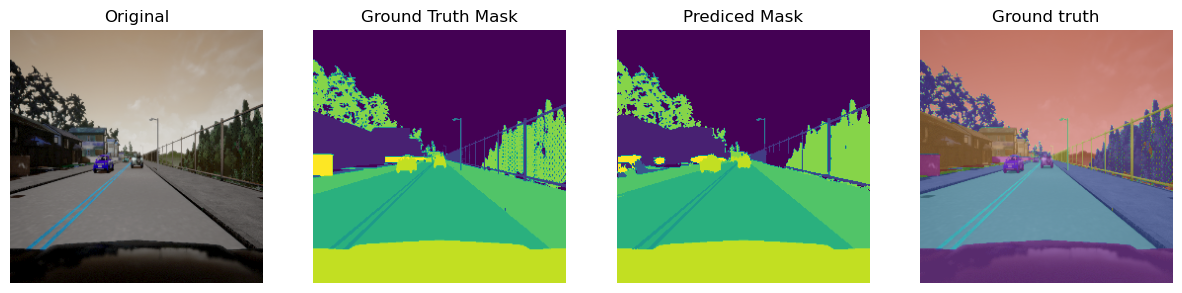

1/1 [==============================] - 0s 30ms/step


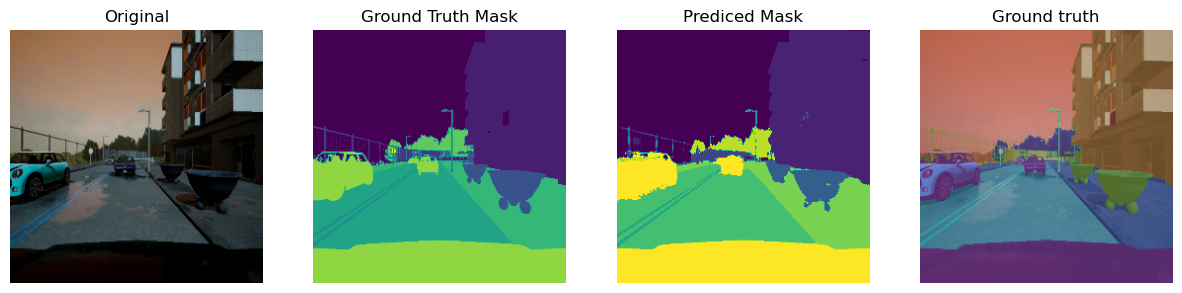

1/1 [==============================] - 0s 29ms/step


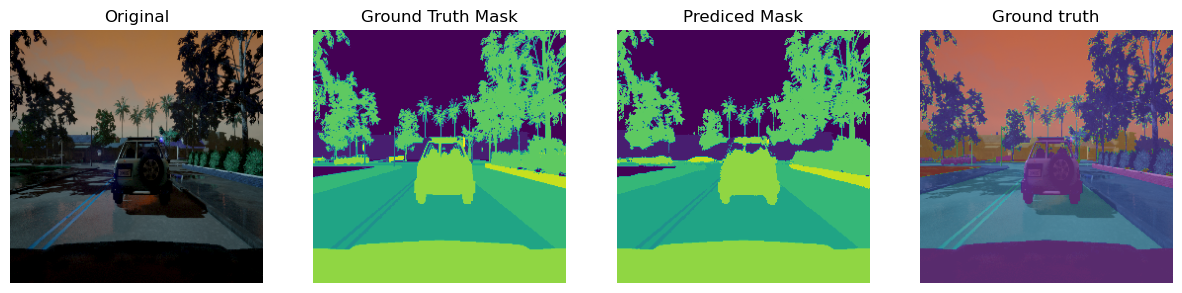

1/1 [==============================] - 0s 29ms/step


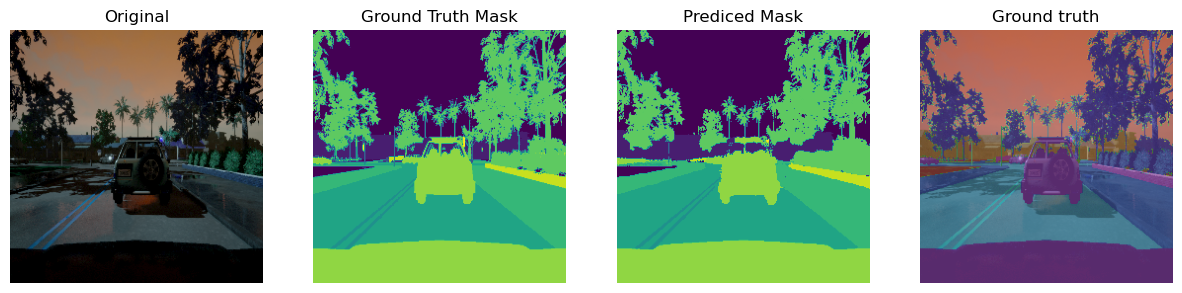

1/1 [==============================] - 0s 28ms/step


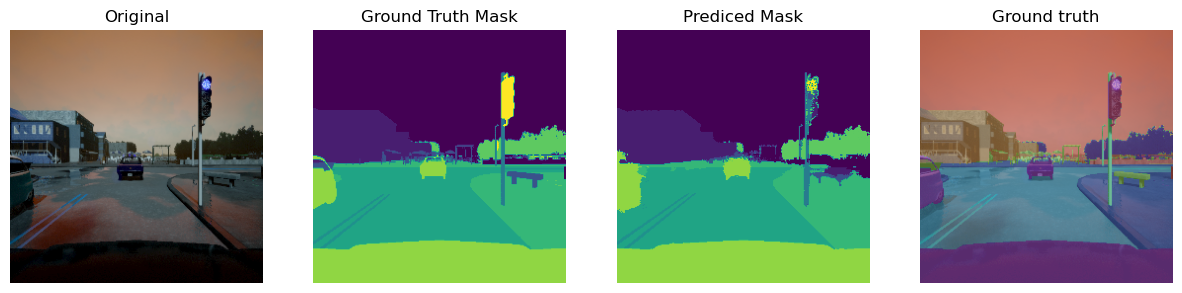

1/1 [==============================] - 0s 28ms/step


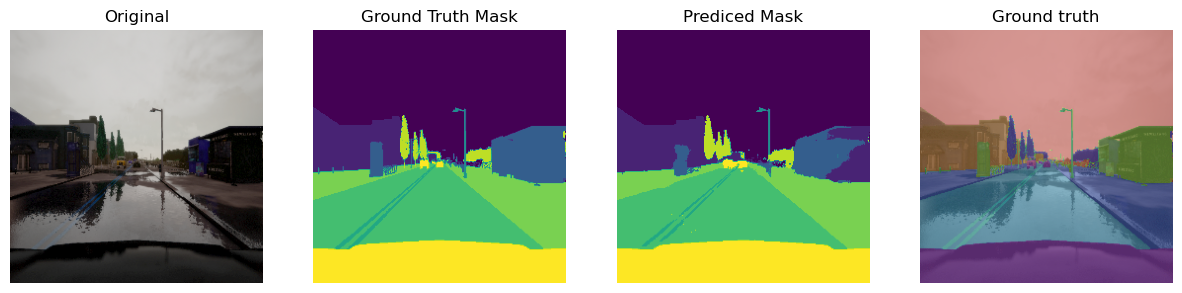

1/1 [==============================] - 0s 28ms/step


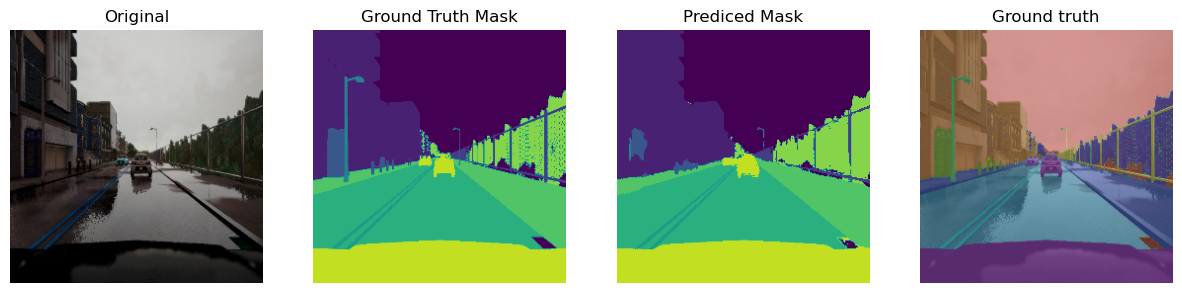

1/1 [==============================] - 0s 27ms/step


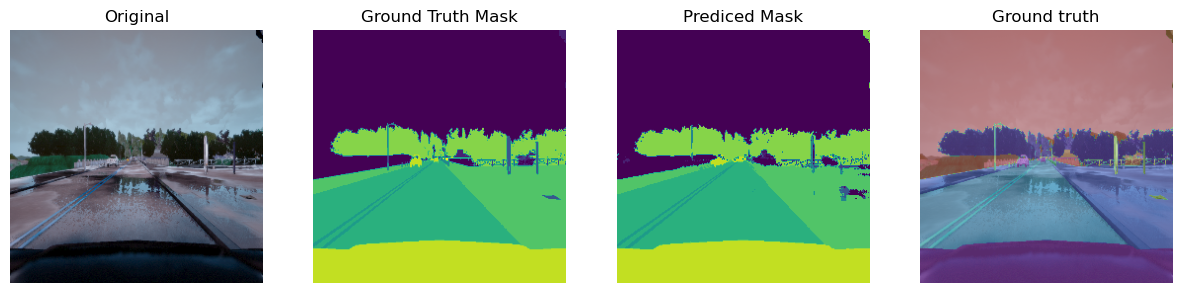

1/1 [==============================] - 0s 29ms/step


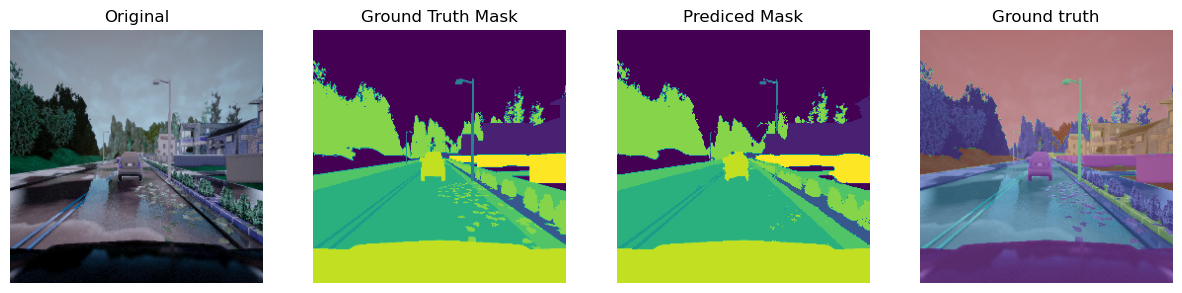

In [23]:
#prediction
max_show = 12
test_iter = iter(test_gen)
for i in range(max_show):
    images, masks = next(test_iter)
    mask_color = give_color_to_seg_img(masks[0])

    preds = model.predict(images)
    pred_masks = np.argmax(preds, axis = 3)
    pred_mask_color = give_color_to_seg_img(pred_masks[0])
    fig, ax = plt.subplots(1, 4, figsize=(15, 6))
    
    for a in ax:
        a.axis('off')

    ax[0].imshow(images[0])
    ax[0].set_title('Original')
    
    ax[1].imshow(masks[0])
    ax[1].set_title('Ground Truth Mask')
    
    ax[2].imshow(pred_masks[0])
    ax[2].set_title('Prediced Mask')
    
    ax[3].imshow(images[0] * 0.5 + mask_color * 0.5)
    ax[3].set_title('Ground truth')
    plt.savefig(f"pred_{i}.jpg", dpi=150)
    plt.show()